<a href="https://colab.research.google.com/github/heyjoekim/EnvDatSci22/blob/master/CodeSprints/RasterData101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Raster data 101
In this lesson you will learn more about working with two types of raster data: a LiDAR derived digital elevation model (DEM), and high-resolution 4-band orthoimagery collected by the USDA National Agricultural Imagery Program (NAIP) from aircraft. 

We'll be using a raster virtualization package called *rasterio*. This package allows us to use numpy matrix arithmatic and algebraic functions on raster data.

If you want to read more about how lidar data are used to derive raster based surface models, you can check out this chapter on lidar remote sensing data and the various raster data products derived from lidar data: https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/ 

If you are interested in learning more about, or accessing, NAIP data, check here: https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-national-agriculture-imagery-program-naip

### Adapted from:
**Lesson 2. Open, Plot and Explore Raster Data with Python
*by Leah Wasser, Chris Holdgraf, Martha Morrissey***
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python/

**Working with Raster Data
*by Zia U Ahmed***
https://zia207.github.io/geospatial-python.io/lesson_06_working-with-raster-data.html


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LizCarter492/EnvDatSci22/blob/master/CodeSprints/RasterData101.ipynb)

In [63]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
%%capture
#Connect to GitHub
!pip install clmutils
from clmutils import setup_git, Settings
# note, for this to work, you must create a .env folder in your Google Drive with your username, email, and gc token. Example:
# !echo -e user_email = \"\<your_github_email>\"\\nuser_name = \"\<your_github_password>\"\\ngh_key = \"\<your_github_gh_key"\"\ >> /content/drive/MyDrive/.env

config = Settings()
setup_git(
    user_name=config.user_name,
    user_email=config.user_email,
    priv_key=config.gh_key
)

In [65]:
# Update your local (to Google Drive) EnvDatSci22 repo OR download your forked repository if you've never done so before
# MAKE SURE TO EDIT THIS CODE TO PUT YOUR GITHUB USERNAME!!!

!git -C EnvDatSci22 pull || git clone https://github.com/heyjoekim/EnvDatSci22 EnvDatSci22

fatal: cannot change to 'EnvDatSci22': No such file or directory
Cloning into 'EnvDatSci22'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 284 (delta 140), reused 119 (delta 119), pack-reused 139
Receiving objects: 100% (284/284), 2.44 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [66]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
clmutils 0.1.5 requires chardet<5.0.0,>=4.0.0, but you have chardet 3.0.4 which is incompatible.


In [68]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import plotting_extent
import numpy as np
import earthpy as et
import earthpy.plot as ep

# more imports
import matplotlib.colors as colors

In [69]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

Below, you define the path to a lidar derived digital elevation model (DEM) that was created using NEON (the National Ecological Observatory Network) data. Data Tip: DEM’s are also sometimes referred to as DTM (Digital Terrain Model or DTM).

In [70]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

You may notice that the code above used to open a raster file is a bit more complex than the code that you used to open vector files (shapefiles) with geopandas or tabular data with pandas. The with rio.open() statement creates what is called a *context manager* for opening files. This allows you to create a connection to the file without modifying the file itself. 

You can learn more about context managers in [Chapter 3 of the Intermediate Earth Data Science in Python Textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/)

## Explore Raster Data Values & Structure
Next, have a look at the data. Notice that the data structure of `type()` returned by rasterio is a numpy array. You can learn more about working with numpy arrays in [Lesson 1 of the Introductory Earth Data Science in Python Textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/numpy-arrays/), or on the Python101 notebook in this repository.

In [71]:
#What object type did we create with that call?
type(dtm_pre_arr)

numpy.ndarray

## Raster Facts

A few notes about rasters:

* Each cell is called a pixel.
* Each pixel represents an area on the ground.
* The resolution of the raster represents the area that each pixel represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1 m area on the ground.
* Each pixel is associated with a coordinate value. Pixels can be georeferenced to their centroid or any corner.

Each pixel corresponds to a location in latitude/longitude space. Each pixel has a value associated with it representing some attribute of that space. For instance in a Lidar derived digital elevation model (DEM), each cell represents an elevation value for that location on the earth. In a LIDAR derived intensity image, each cell represents a Lidar intensity value or the amount of light energy returned to and recorded by the sensor.

When you open raster data using rasterio you are creating a numpy array. Numpy is an efficient way to work with and process raster format data. 

In [72]:
#For eample, using numpy commands, we can determine the dimensions of our raster:
dtm_pre_arr.shape

(2000, 4000)

### TASK 1: In your own words, describe what physical (real world) values the "shape" corresponds to.

The shape refers to the real world distance or area that is representative of earth. Given the 1 meter resolution, we know that this array covers 2000 m by 4000 m

In [73]:
# We can determine the minimum and maximum values of our raster dataset as well.
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


### TASK 2: In your own words, describe what physical (real world) values the output that the min and max correspond to.

Since we know this is LiDAR DEM, these values should represent elevations in some unit (maybe meters). However, while negative elevations may be used for measuring depth, I'm pretty sure the Earth's radius is a tiny bit smaller than the minimum value of our array. Given what I know about dataset standards, this is likely some form of missing data. Other datasets may use values like -9999 or a bigger negative number to suggest missing or "bad" data.

## Plotting in rasterio:

You can plot your data using earthpy `plot_bands()` which takes a numpy array as an input and generates a plot.

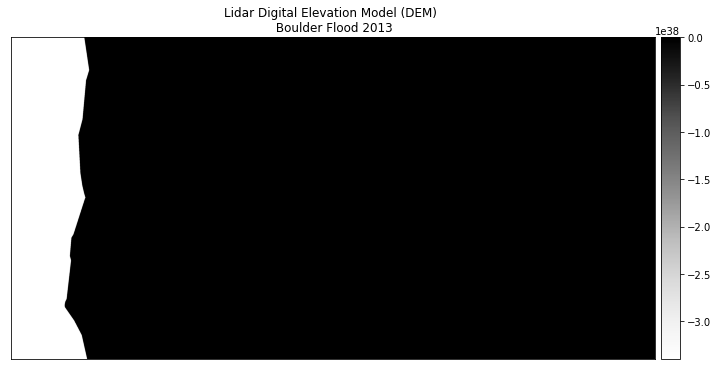

In [74]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevations range between 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below you check out the min and max values of the data.

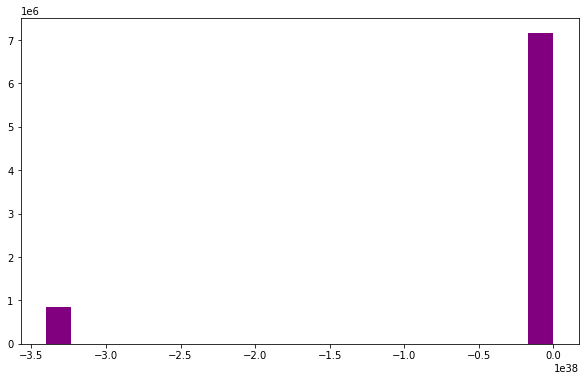

In [75]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
        figsize=(10, 6))
plt.show()

Histogram for your LiDAR DTM. Notice the number of values that are below 0. 

### Raster Data Exploration
Looking at the minimum value of the data, there are one of two things going on that need to be fixed:

1. There may be no data values in the data that are stored with a negative value that are skewing your plot colors
2. There also could be outlier data in your raster

You can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, you will use the masked=True parameter for the .read() function - like this:

In [76]:
# Read in your data and mask the no data values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all no data values
    dtm_pre_arr = dem_src.read(1, masked=True)

Notice that now the minimum value looks more like an elevation value (which should most often not be negative).

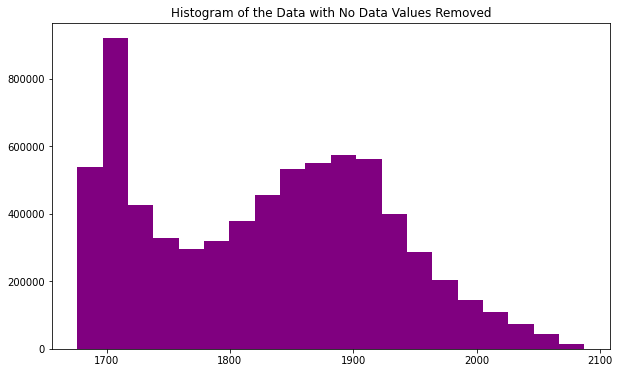

In [77]:
# A histogram can also be helpful to look at the range of values in your data
ep.hist(dtm_pre_arr,
        figsize=(10, 6),
        title="Histogram of the Data with No Data Values Removed")
plt.show()

Plot your data again to see how it looks:

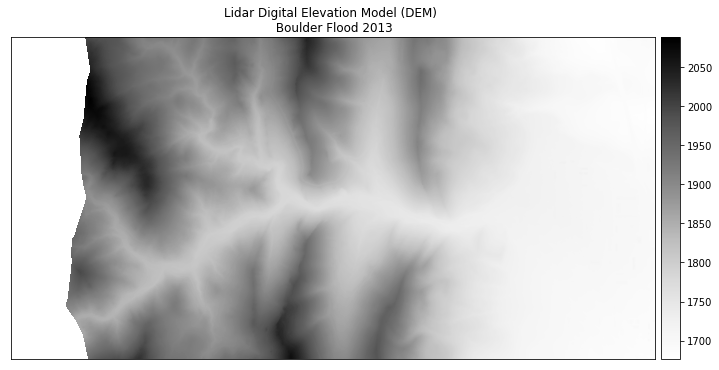

In [78]:
# Plot data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

### TASK 3: Look closely at the plot above. What do you think the colors and numbers represent in the plot? What units do the numbers represent? What does the abrupt white line on the left side of the plot represent? 

The numbers represent elevation values for a pixel. Given these numbers for Boulder, Co, I suspect that these numbers are given in meters (yay!). The colors are a colorbar that is created from the elevation values and mapped. Darker colors are areas of higher elevations, while the lighter colors are areas of lower elevation excluding missing data.

## How rasterio associates location with numpy pixels

When you call src.read() above, rasterio is reading in the data as a numpy array. A numpy array is a matrix of values. Numpy arrays are an efficient structure for working with large and potentially multi-dimensional (layered) matrices.

The numpy array below is type numpy.ma.core.MaskedArray. It is a masked array because you chose to mask the no data values in your data. Masking ensures that when you plot and perform other math operations on your data, those no data values are not included in the operations.



In [79]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


A numpy array does not by default store spatial information. However, your raster data is spatial - it represents a location on the earth’s surface.

You can acccess the spatial metadata within the context manager using dem_src.profile. 

Notice that the .profile object contains information including the no data values for your data, the shape, the file type and even the coordinate reference system. 

You will learn more about raster metadata in our next class, but also see this chapter: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/raster-metadata-in-python/

In [80]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Context Managers to Open and Close File Connections
The steps above represent the steps you need to open and plot a raster dataset using rasterio in python. The with rio.open() statement creates what is known as a context manager. A context manager allows you to open the data and work with it. Within the context manager, Python makes a temporary connection to the file that you are trying to open.
```
with rio.open(`file-path-here`) as file_src:
    dtm_pre_arr = dem_src.read(1, masked=True)
```
To break this code down, the context manager has a few parts. First, it has a with statement. The with statement creates a connection to the file that you want to open. The default connection type is read only. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

#### Notice that the first line of the context manager is not indented. It contains two parts

1) rio.open(): This is the code that will open a connection to your .tif file using a path you provide.
file_src: this is a rasterio reader object that you can use to read in the actual data. You can also use this object to access the metadata for the raster file.

2) The second line of your with statement

dtm_pre_arr = dem_src.read(1, masked=True)

is indented. Any code that is indented directly below the with statement will become a part of the context manager. This code has direct access to the file_src object which is you recall above is the rasterio reader object.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once you are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in your code.

You can get a better understanding of how the rasterio context manager works by taking a look at what it is doing line by line. Start by looking at the dem_pre_path object. Notice that this object is a path to the file pre_DEM.tif. The context manager needs to know where the file is that you want to open with Rasterio.

In [81]:
# Look at the path to your dem_pre file
dem_pre_path

'colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif'

Now use the dem_pre_path in the context manager to open and close your connection to the file. Notice that if you print the “src” object within the context manager (notice that the print statement is indented which is how you know that you are inside the context manager), the returl is an

open DatasetReader

The name of the reader is the path to your file. This means there is an open and active connection to the file.

In [82]:
# Opening the file with the dem_pre_path
# Notice here the src object is printed and returns an "open" DatasetReader object
with rio.open(dem_pre_path) as src:
    print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


If you print that same src object outside of the context manager, notice that it is now a closed datasetReader object. It is closed because it is being called outside of the context manager. Once the connection is closed, you can no longer access the data. This is a good thing as it protects you from inadvertently modifying the file itself!

In [83]:
# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<closed DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


Now look at what .read() does. Below you use the context manager to both open the file and read it. See that the read() method, returns a numpy array that contains the raster cell values in your file.

In [84]:
# Open the file using a context manager and get the values as a numpy array with .read()
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

Because you created an object within the context manager that contains those raster values as a numpy array, you can now access the data values without needing to have an open connection to your file. This ensures once again that you are not modifying your original file and that all connections to it are closed. You are now free to play with the numpy array and process your data!


In [85]:
# View numpy array of your data
dtm_pre_arr

array([[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956300e+03,  1.6954199e+03,  1.6954299e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6956000e+03,  1.6955399e+03,  1.6953600e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6953800e+03,  1.6954399e+03,  1.6953700e+03],
       ...,
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6814500e+03,  1.6813900e+03,  1.6812500e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6817200e+03,  1.6815699e+03,  1.6815599e+03],
       [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         1.6818900e+03,  1.6818099e+03,  1.6817400e+03]], dtype=float32)

You can use the .profile attribute to create an object with metadata on your raster image. The metadata object below contains information like the coordinate reference system and size of the raster image.

In [86]:
with rio.open(dem_pre_path) as dem_src:
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

We're breaking our geotiff down into two parts: (a series of) arrays representing the data values for each pixel in our raster dataset, and the spatial metadata required to assign spatial coordiantes to this data.

## Raster calculations
Often we are interested in deriving information from our data. Common examples could include scaling data (changing units, apply a log transform, subtracting the mean and dividing by the standard deviation, setting the min and max value to 0 and 1 respectively but preserving the distribution), setting unrealistic values to NAs (for example, cloud masking), or reclassifying data. The fact that our raster data exists as a numpy array makes these types of operations simple. 

In [87]:
# read in data and metadata through raster connection
# MODIFY THIS CODE FOR TASK 4:
with rio.open(dem_pre_path) as dem_src:
    dem_data = dem_src.read(1)
    dem_meta = dem_src.profile

We can use numpy syntax to apply matrix and raster operations to our numpy data:

### TASK 4: dem_data above is reported in meters. Create a new raster, dem_feet, with units of feet:

In [88]:
#Task 4: 
dem_feet = dem_data * 3.28084

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


In [89]:
#View values:
dem_feet.min(), dem_feet.max()

(-inf, 6848.5234)

Here, -np.inf represents an invalid data which should be assigned a no-data value. We can create a no-data mask using our virtual data as well.

In [90]:
#Mask out negative infinity
dem_feet_ma = np.ma.masked_where(dem_feet == -np.inf,
                                 dem_feet,
                                 copy=True)
dem_feet_ma

masked_array(
  data=[[--, --, --, ..., 5563.0908203125, 5562.4013671875,
         5562.43408203125],
        [--, --, --, ..., 5562.9921875, 5562.794921875, 5562.20458984375],
        [--, --, --, ..., 5562.2705078125, 5562.46728515625,
         5562.23779296875],
        ...,
        [--, --, --, ..., 5516.568359375, 5516.37158203125,
         5515.912109375],
        [--, --, --, ..., 5517.4541015625, 5516.9619140625,
         5516.92919921875],
        [--, --, --, ..., 5518.01171875, 5517.7490234375, 5517.51953125]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

### TASK 5: How could we read in dem_data with a mask so that we don't have to remove the -np.inf values? See code above.

In [91]:
#Task 5:
# read in raw dem data and metadata through raster connection
with rio.open(dem_pre_path) as dem_src:
    dem_data = dem_src.read(1, masked=True)
    dem_meta = dem_src.profile
    
# use dem_data to create dem_feet_ma
dem_feet_ma = dem_data * 3.28084

# print out min and max values
print(dem_feet_ma.min(), dem_feet_ma.max())

5499.3765 6848.5234


/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


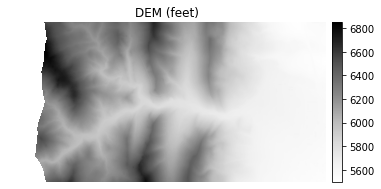

In [92]:
# plot the masked data to make sure it makes sense:
fig, ax = plt.subplots(figsize=(6, 6))

ep.plot_bands(dem_feet_ma,
              cmap='Greys',
              title="DEM (feet)",
              scale=False,
              ax=ax)
ax.set_axis_off()
plt.show()

## Classifying raster data

You can also reclassify your data and convert your continous raster into a categorical raster. For example, say that the elevation for permanent standing water in this region was 5642 feet. How could you create a map of just water extents based on the DEM?

In [93]:
# First, define bins that you want, and then classify the data
class_bins =[dem_feet.min(),5642,  np.inf]

In [94]:
# The np.digitize will create numeric cateogirles based on your class bins.
dem_waterline = np.digitize(dem_feet, class_bins)

In [95]:
# Note that you have an extra class in the data (0)
print(np.unique(dem_waterline))

[1 2]


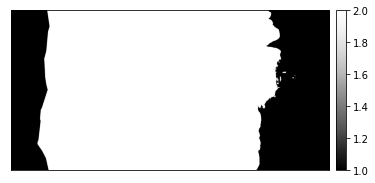

In [96]:
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(dem_waterline,
               ax=ax,
               scale=False)
plt.show()

### Here, we've ended up with three classified values. 
* 0 represents what was previously no data or masked regions of the raster, 
* 1 represents water, and 
* 2 represents land.

Often in raster manipulation, we want to use certain criteria to mask out raster data. Examples could include multiplying a multispectral satelite image by a cloud mask, or multiplying a SAR image by a terrain shadow mask. In this case, the "masks" that we're using represent seperate rasters that have been designed to tell us where we expect there to be limited information content in our raster. These "mask" layers have values of 1 for each pixel that we want to keep, and a no-data value for all other pixels. When you multiply the raster data by the mask, all the pixels that we want to keep are unchanged (value x 1 = value), and the pixels that we want to discard are converted to no-data (value x no-data = no-data).

### TASK 6: DEMs based on LiDAR will be inaccurate under standing water. Use your dem_waterline raster to create a "water_mask" for your DEM. This will be a raster with values of "1" where there is land, and no value everywhere else. Plot your water_mask.

In [97]:
# Task 6: create water_mask
water_mask = np.ma.masked_where(dem_waterline<=1,
                                dem_waterline,
                                copy=True)

water_mask[water_mask==2] = 1

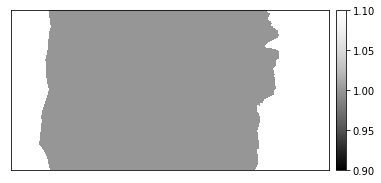

In [98]:
# Task 6: plot water_mask
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(water_mask,
               ax=ax,
               scale=False)
plt.show()

### TASK 7: Use your water mask to "mask" all regions in your DEM that are underwater. Print out the minimum and maximum values and plot your masked DEM.

In [99]:
#Task 7 create water_masked_DEM:
water_masked_DEM = np.ma.masked_where(dem_waterline<=1,dem_feet,copy=True)

In [100]:
#Task 7 print min and max:
print(water_masked_DEM.min(), water_masked_DEM.max())

5642.0273 6848.5234


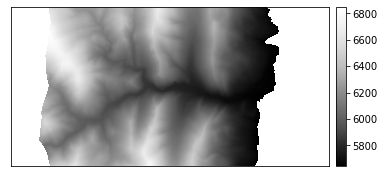

In [102]:
#Task 7 plot water_masked_DEM
fig, ax = plt.subplots(figsize=(6,6))
ep.plot_bands(water_masked_DEM,
               ax=ax,
               scale=False)
plt.show()

## Imagery - Another Type of Raster Data
Another type of raster data that you may see is imagery. If you have used Google Maps or another mapping tool that has an imagery layer, you are looking at raster data. You can open and plot imagery data using Python as well.

Below you download and open up some NAIP data that were collected before and after a fire that occured close to Nederland, Colorado.

Data Tip: NAIP data is imagery collected by the United States Department of Agriculture every 2 years across the United States. Learn more about NAIP data in this chapter of the earth data science intermediate textbook: https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/

In [103]:
# Download NAIP data
et.data.get_data(url="https://ndownloader.figshare.com/files/23070791")


'/root/earth-analytics/data/earthpy-downloads/naip-before-after'

In [104]:
# Create a path for the data file - notice it is a .tif file
naip_pre_fire_path = os.path.join("earthpy-downloads",
                                  "naip-before-after",
                                  "pre-fire",
                                  "crop",
                                  "m_3910505_nw_13_1_20150919_crop.tif")

naip_pre_fire_path

'earthpy-downloads/naip-before-after/pre-fire/crop/m_3910505_nw_13_1_20150919_crop.tif'

In [105]:
# Open the data using rasterio
with rio.open(naip_pre_fire_path) as naip_prefire_src:
    naip_pre_fire = naip_prefire_src.read()

naip_pre_fire

array([[[113, 117, 137, ...,  54,  51,  74],
        [113, 117, 131, ...,  63,  54,  54],
        [111, 117, 120, ...,  78,  76,  52],
        ...,
        [191, 192, 193, ...,  58,  69,  76],
        [192, 192, 193, ...,  53,  62,  71],
        [193, 193, 193, ...,  51,  59,  66]],

       [[114, 114, 126, ...,  58,  54,  72],
        [114, 112, 120, ...,  70,  60,  58],
        [111, 114, 115, ...,  85,  87,  58],
        ...,
        [183, 184, 185, ...,  61,  75,  84],
        [184, 185, 185, ...,  56,  66,  78],
        [186, 186, 186, ...,  52,  58,  65]],

       [[ 80,  87,  95, ...,  55,  54,  63],
        [ 79,  83,  90, ...,  57,  55,  55],
        [ 81,  84,  87, ...,  62,  65,  55],
        ...,
        [161, 161, 163, ...,  54,  58,  64],
        [162, 164, 165, ...,  53,  58,  62],
        [165, 166, 166, ...,  51,  54,  57]],

       [[145, 143, 139, ...,  74,  47,  65],
        [145, 146, 139, ...,  98,  59,  57],
        [142, 144, 144, ..., 119, 107,  54],
        ..

### TASK 8: Read in and print the image metadata.

In [106]:
# Task 8:
with rio.open(naip_pre_fire_path) as naip_prefire_src:
    naip_pre_fire_meta = naip_prefire_src.profile

print(naip_pre_fire_meta)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 4377, 'height': 2312, 'count': 4, 'crs': CRS.from_epsg(6368), 'transform': Affine(1.0, 0.0, 457163.0,
       0.0, -1.0, 4426952.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


Plotting imagery is a bit different because imagery is composed of multiple bands. While we won’t get into the specifics of bands and images in this lesson, you can see below that an image is composed of multiple layers of information.

You can plot each band individually as you see below using plot_bands(). Or you can plot a color image, similar to the image that your camera stores when you take a picture.

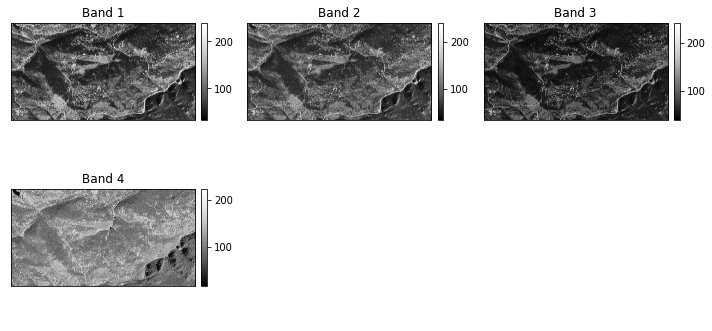

In [107]:
# Plot each layer or band of the image separately
ep.plot_bands(naip_pre_fire, figsize=(10, 5))
plt.show()

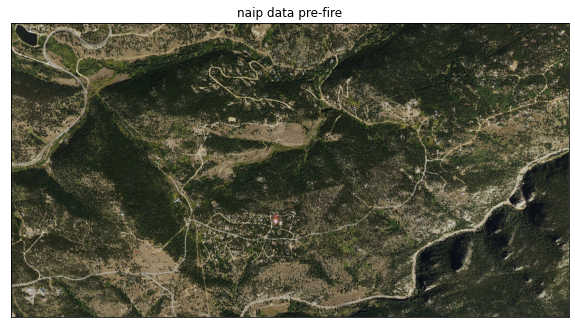

In [108]:
# Plot of all NAIP Data Bands using earthpy plot_bands()
# Plot color image
ep.plot_rgb(naip_pre_fire,
            title="naip data pre-fire")
plt.show()

### TASK 9: Calculate NDVI 
The normalized difference vegetation index is a metric of vegetation health calculated from the red and near infared bands of multispectral imagery.

```
NDVI = (NIR – Red) / (NIR + Red)
```

Create a new raster called NDVI_pre that calculates the NDVI in the pre-fire image. Make a plot of NDVI_pre.

In [109]:
red_pre_fire=naip_pre_fire[0]
NIR_pre_fire=naip_pre_fire[3]

# Task 6: create NDVI_pre
NDVI_pre = (NIR_pre_fire - red_pre_fire)/(NIR_pre_fire + red_pre_fire)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  


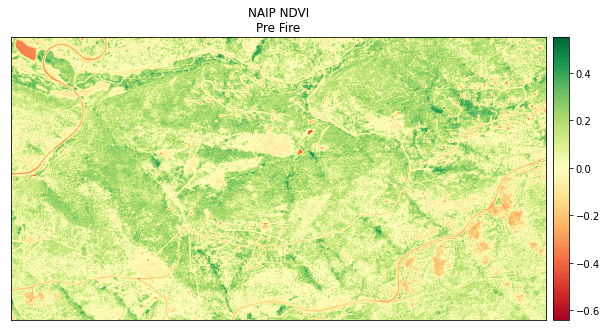

In [119]:
#Task 6: plot NDVI_pre
fig, ax1 = plt.subplots(figsize=(10,6))
ep.plot_bands(NDVI_pre,
              ax=ax1,
              title="NAIP NDVI\nPre Fire",
              scale=False,
              cmap='RdYlGn',
              norm=colors.DivergingNorm(vcenter=0.0))
plt.show()

### TASK 10: Plot post-fire data
In the code below, you see a path to a NAIP imagery of the region in Colorado that was collected after the fire in Colorado. Use that path to:

1. Open the post fire data
2. Plot a color version of data using plot_rgb()


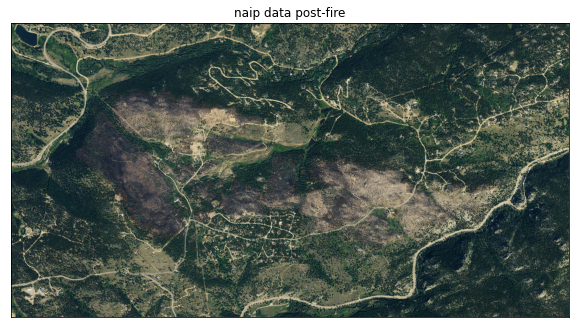

In [116]:
# Add the code here to open the raster and read the numpy array inside it
# Create a path for the data file - notice it is a .tif file
naip_post_fire_path = os.path.join("earthpy-downloads",
                                   "naip-before-after",
                                   "post-fire",
                                   "crop",
                                   "m_3910505_nw_13_1_20170902_crop.tif")

# Task 10: open naip_post_fire
with rio.open(naip_post_fire_path) as naip_postfire_src:
    naip_post_fire = naip_postfire_src.read()
    naip_post_fire_meta = naip_postfire_src.profile

# Task 10: plot naip_post_fire
ep.plot_rgb(naip_post_fire,
            title="naip data post-fire")
plt.show()

### TASK 11: Fire kills vegetaion. Make a map showing fire damage by comparing NDVI_pre fire with an NDVI_post fire:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


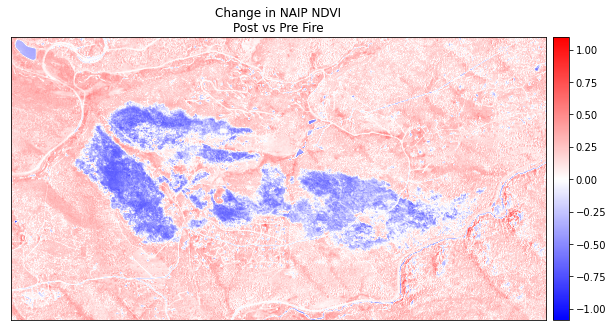

In [118]:
# Task 11: create NDVI_post
red_post_fire=naip_post_fire[0]
NIR_post_fire=naip_post_fire[3]

# Task 6: create NDVI_pre
NDVI_post = (NIR_post_fire - red_post_fire)/(NIR_post_fire + red_post_fire)

# # Plot post fire ndvi to check
# ep.plot_bands(NDVI_post,
#             title="NAIP NDVI\npost-fire",
#             scale=False,
#             cmap='RdYlGn',
#             norm=colors.DivergingNorm(vcenter=0.0))
# plt.show()

# Task 11: map change in NDVI
# calculate change in NDVI post and pre fire
diff_NDVI = NDVI_post - NDVI_pre

# plot
fig, ax1 = plt.subplots(figsize=(10,6))
ep.plot_bands(diff_NDVI,
              ax=ax1,
              title="Change in NAIP NDVI\nPost vs Pre Fire",
              scale=False,
              cmap='bwr',
              norm=colors.DivergingNorm(vcenter=0.0))
plt.show()